## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Carga datos y representa la serie

In [2]:
df = pd.read_csv('C:/Users/lydia/OneDrive/Escritorio/Bootcamp/Machine_Learning/3-Time_Series/ejercicios/data/AirPassengers.csv')
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [3]:
df.tail()

,date,value
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
#Pasamos la columna a fecha
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [6]:
df.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


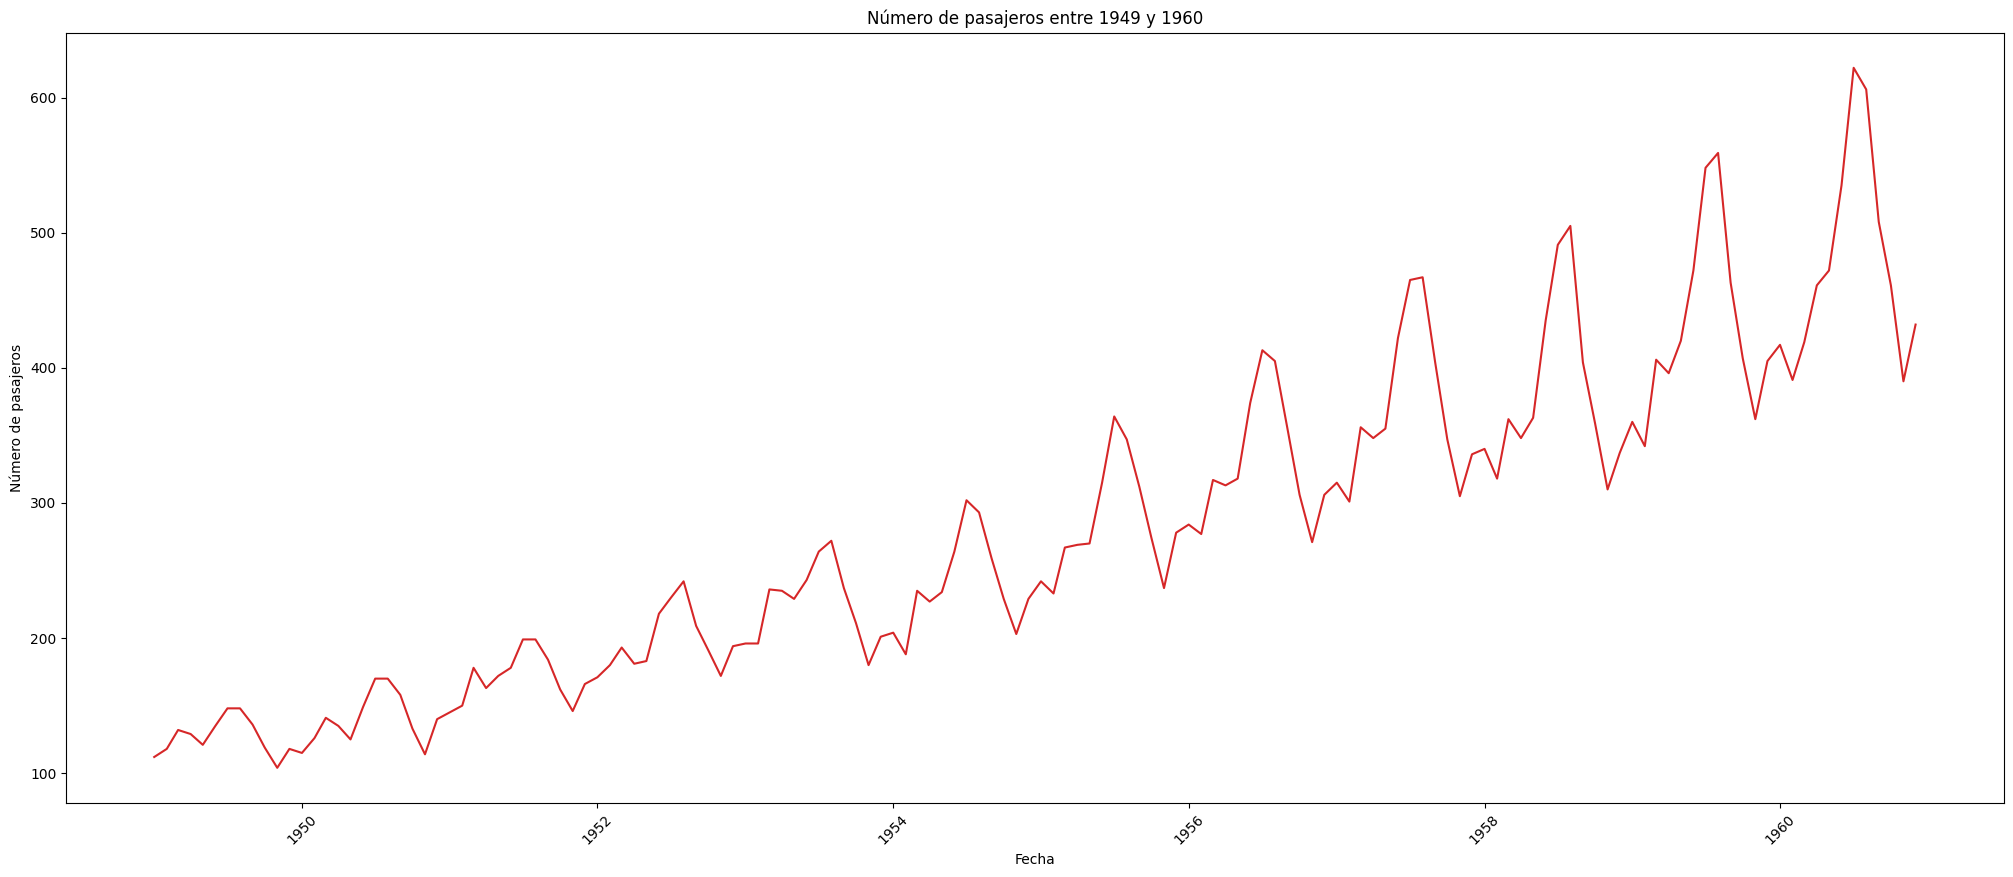

In [7]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Número de pasajeros', dpi=100):
    plt.figure(figsize=(25,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=45)
    plt.show();

plot_df(df, x=df.date, y=df.value, title='Número de pasajeros entre 1949 y 1960') 

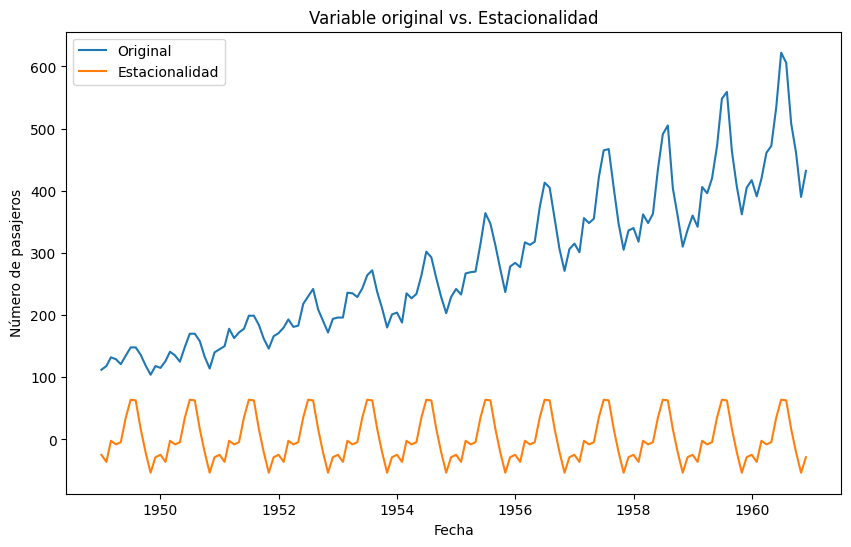

In [8]:
#Obtener estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose

# Establecemos la columna 'date' como el índice del dataframe
df.set_index('date', inplace=True)

# Descomponemos la serie 
result = seasonal_decompose(df['value'], model='additive')

# Obtenemos el componente de estacionalidad
seasonality = result.seasonal

# Graficamos la variable original vs. la estacionalidad
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['value'], label='Original')
ax.plot(df.index, seasonality, label='Estacionalidad')

# Títulos
ax.set_title('Variable original vs. Estacionalidad')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de pasajeros')
ax.legend()
plt.show();

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

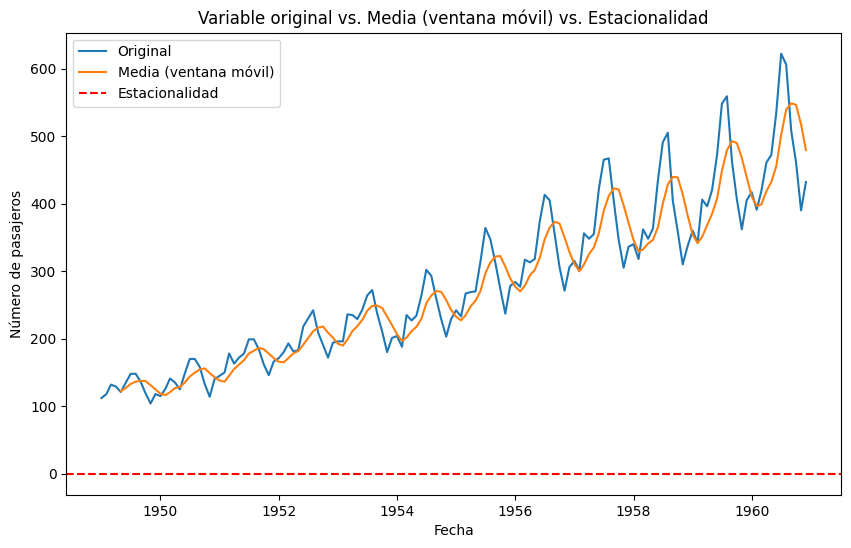

In [12]:
# Calculamos la media utilizando rolling window
window_size = 5
rolling_mean = df['value'].rolling(window_size).mean()

# Calculamos la media de la estacionalidad
seasonality_mean = seasonality.mean()  # Reemplaza 'seasonality' con tu variable de estacionalidad

# Graficamos
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['value'], label='Original')
ax.plot(df.index, rolling_mean, label='Media (ventana móvil)')
ax.axhline(y=seasonality_mean, color='r', linestyle='--', label='Estacionalidad')

# Títulos
ax.set_title('Variable original vs. Media (ventana móvil) vs. Estacionalidad')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de pasajeros')
ax.legend()
plt.show();

## 3. Comprueba de manera estadística si la serie es o no stationary.

**Root Test Stationary**

La hipótesis nula de los test supone que la serie NO es estacionaria. Si el resultado del test queda por debajo del nivel de significación (0.05), rechazaremos la hipótesis nula en favor de la alternativa. En este caso, con un resultado de **0.9918802434376409** no se puede rechazar la hipótesis nula. Por lo tanto, la serie es NO estacionaria.

In [13]:
#Root Test Stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['value'].values)
result[1]

0.9918802434376409

## 4. Aplica una transformación logarítmica

In [15]:
# Aplicar una transformación logarítmica a la serie
df['log_value'] = np.log(df['value'])

In [16]:
df.head()

,value,log_value
date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


## 5. Divide en train y test. Guarda 20 muestras para test.

In [66]:
X = df['value'].values
train = X[0:-20]
test = X[-20:]

In [67]:
test.shape

(20,)

## 6. Crea tu primer modelo ARIMA

In [65]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

In [68]:
# Modelo ARIMA manual
model = ARIMA(train, order=(5, 1, 3))

# Ajustar el modelo a los datos de entrenamiento
model_fit = model.fit()

# Imprimir el resumen del modelo
print(model_fit.summary())

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calcular el error cuadrático medio en las predicciones
mse = mean_squared_error(test, predictions)

# Imprimir el error cuadrático medio
print("Error cuadrático medio:", mse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -563.051
Date:                Fri, 14 Jul 2023   AIC                           1144.103
Time:                        11:13:42   BIC                           1169.413
Sample:                             0   HQIC                          1154.384
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5994      0.177     -3.396      0.001      -0.945      -0.253
ar.L2          0.4414      0.124      3.572      0.000       0.199       0.684
ar.L3          0.1770      0.135      1.315      0.1

## 7. Representa en una gráfica los datos de test y tus predicciones.

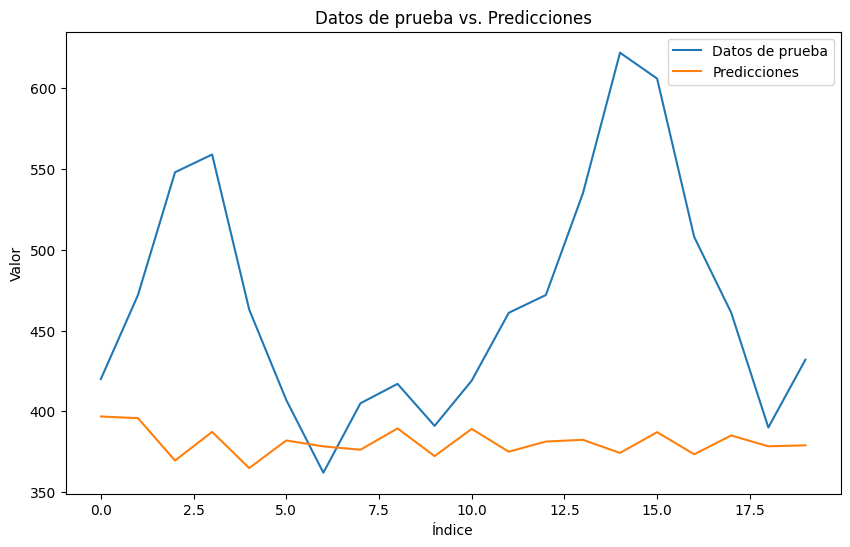

In [69]:
# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(test, label='Datos de prueba')
plt.plot(predictions, label='Predicciones')
plt.title('Datos de prueba vs. Predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show();

## 8. Prueba otros modelos, a ver qué performance presentan.

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [71]:
#Definimos modelo
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Entrenamos
model_sarima_fit = model_sarima.fit()

# predecimos
predictions_sarima = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [72]:
# Calculamos error cuadrático medio
mse_sarima = mean_squared_error(test, predictions_sarima)
print("Error cuadrático medio (SARIMA):", mse_sarima)

Error cuadrático medio (SARIMA): 362.10129761952555


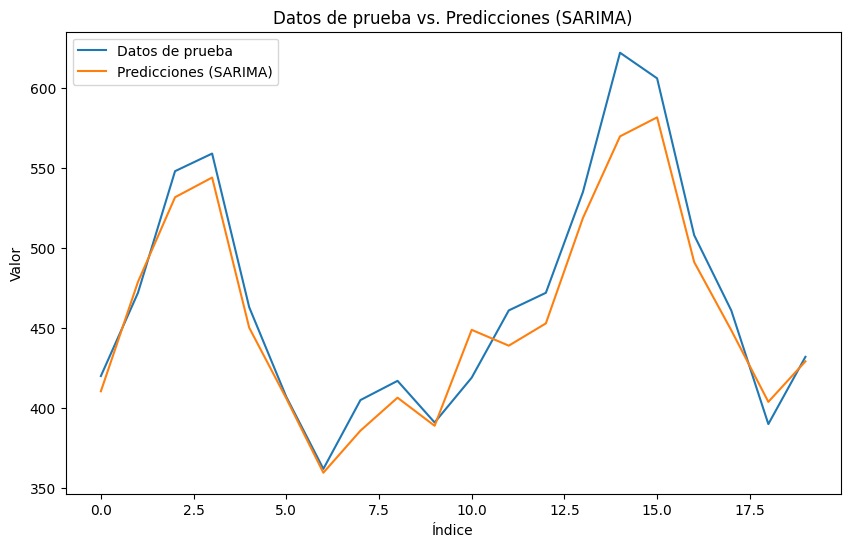

In [73]:
#Graficamos
plt.figure(figsize=(10, 6))
plt.plot(test, label='Datos de prueba')
plt.plot(predictions_sarima, label='Predicciones (SARIMA)')
plt.title('Datos de prueba vs. Predicciones (SARIMA)')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()